# MNE EEG Processing
# Feature Familiarity Response Experiment

In [1]:
# Load in packages
## From FaceWord, ICA, stats
import pip
%pip install mne
!python -m pip install mne
import mne
!python -m pip install pandas
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.system('python -m pip install scikit-learn')
from scipy import stats as st
import statistics as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
!pip install scikit-learn
from EEGModels import EEGNet
import sklearn # scikit-learn is needed to run ICA (Independent Component Analysis)
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #Needed to compare the models

Note: you may need to restart the kernel to use updated packages.


# 1 -- Load data
Additional info: [mne tools](https://mne.tools/stable/overview/datasets_index.html)

In [2]:
raw = mne.io.read_raw_brainvision('C:/Users/gerga/source/eeg-stuff/EEG face-word data/group1.vhdr', eog=('HEOG', 'VEOG'))
raw.load_data()

Extracting parameters from C:/Users/gerga/source/eeg-stuff/EEG face-word data/group1.vhdr...
Setting channel info structure...
Reading 0 ... 1990219  =      0.000 ...  1990.219 secs...


<RawBrainVision | group1.eeg, 32 x 1990220 (1990.2 s), ~485.9 MB, data loaded>

Using matplotlib as 2D backend.


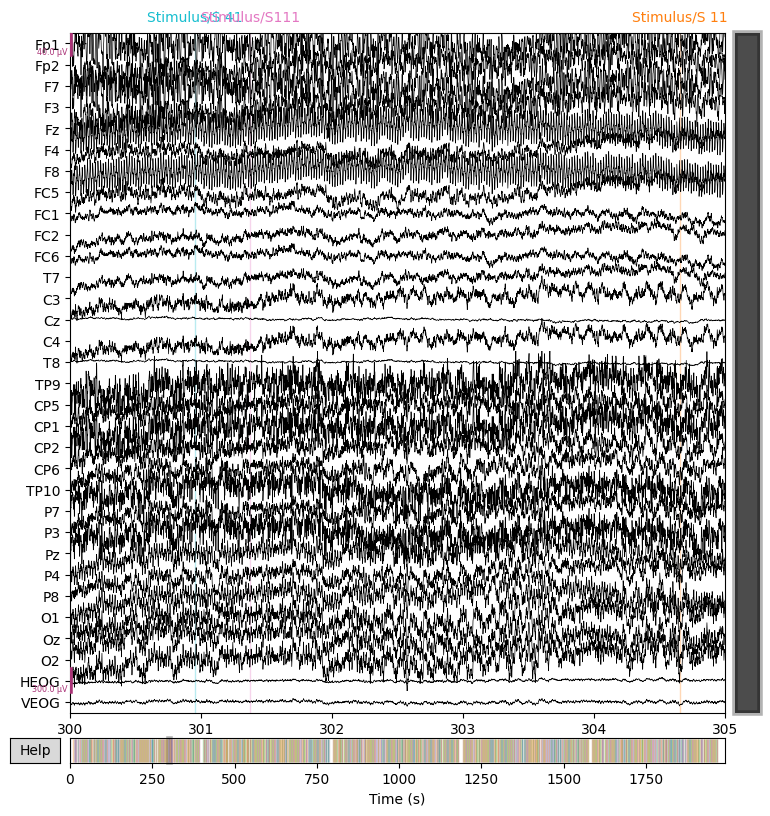

In [3]:
raw.plot(n_channels=32, duration=5, start=300);

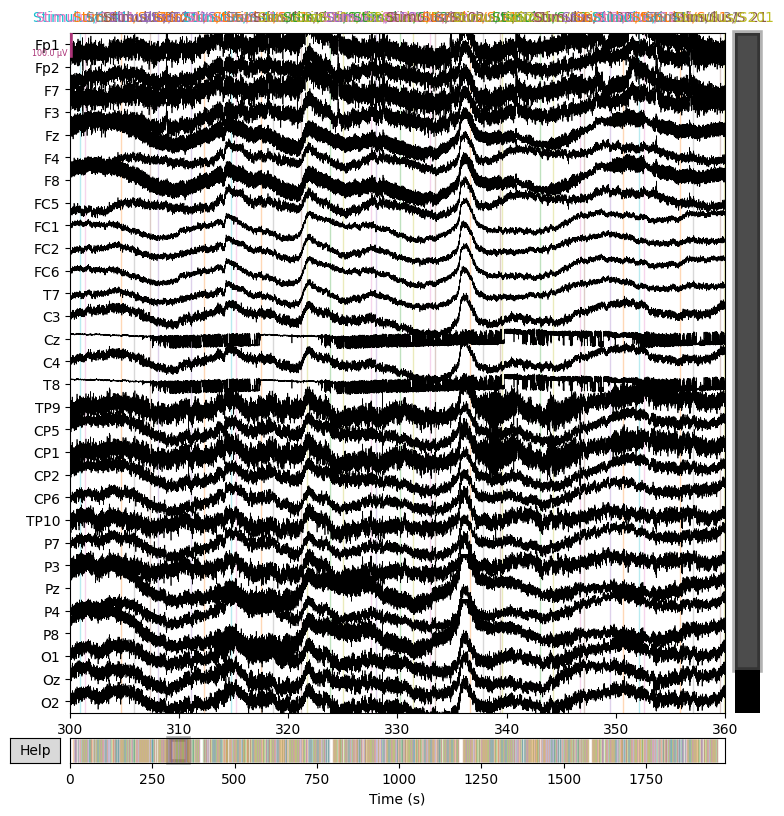

In [4]:
# Try to find bad channels:
raw.plot(n_channels=30, duration=60, start = 300, scalings=dict(eeg=50e-6));

In [5]:
# it seems the Cz and T8 are actually a bit strange
raw.info['bads'] = ['Cz', 'T8', 'Fz', 'F8']
raw.pick_types(meg=False, eeg=True, stim=True, exclude='bads')

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<RawBrainVision | group1.eeg, 26 x 1990220 (1990.2 s), ~394.8 MB, data loaded>

In [6]:
# Specify electrode locations
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)

<RawBrainVision | group1.eeg, 26 x 1990220 (1990.2 s), ~394.8 MB, data loaded>

In [7]:
raw.pick_types(meg=False, eeg=True, stim=True, exclude=[])

raw.set_eeg_reference(ref_channels='average', ch_type='eeg')

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Applying average reference.
Applying a custom ('EEG',) reference.


<RawBrainVision | group1.eeg, 26 x 1990220 (1990.2 s), ~394.8 MB, data loaded>

In [8]:
#Filtering the data
raw.filter(l_freq=40, h_freq=0.1)

#Filtering the data suitable for ICA
# high-pass
raw_fit = raw.copy().filter(1, None)

# low-pass 
raw_fit = raw_fit.filter(None, 40)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    3.2s finished


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    1.5s finished


In [9]:
ica = mne.preprocessing.ICA(n_components=0.95, random_state=7, max_iter=800)
ica.fit(raw_fit)

Fitting ICA to data using 26 channels (please be patient, this may take a while)
Selecting by explained variance: 7 components
Fitting ICA took 6.9s.


<ICA | raw data decomposition, method: fastica (fit in 15 iterations on 1990220 samples), 7 ICA components (26 PCA components available), channel types: eeg, no sources marked for exclusion>

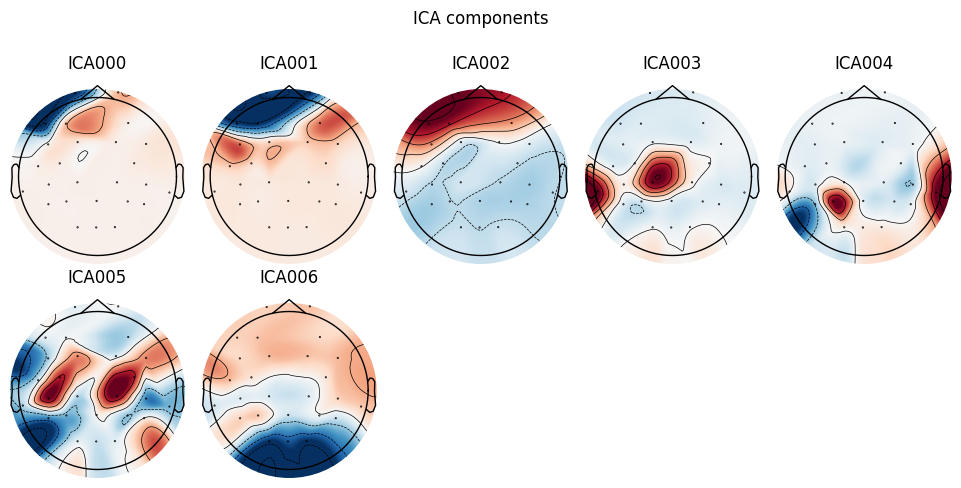

Creating RawArray with float64 data, n_channels=7, n_times=1990220
    Range : 0 ... 1990219 =      0.000 ...  1990.219 secs
Ready.


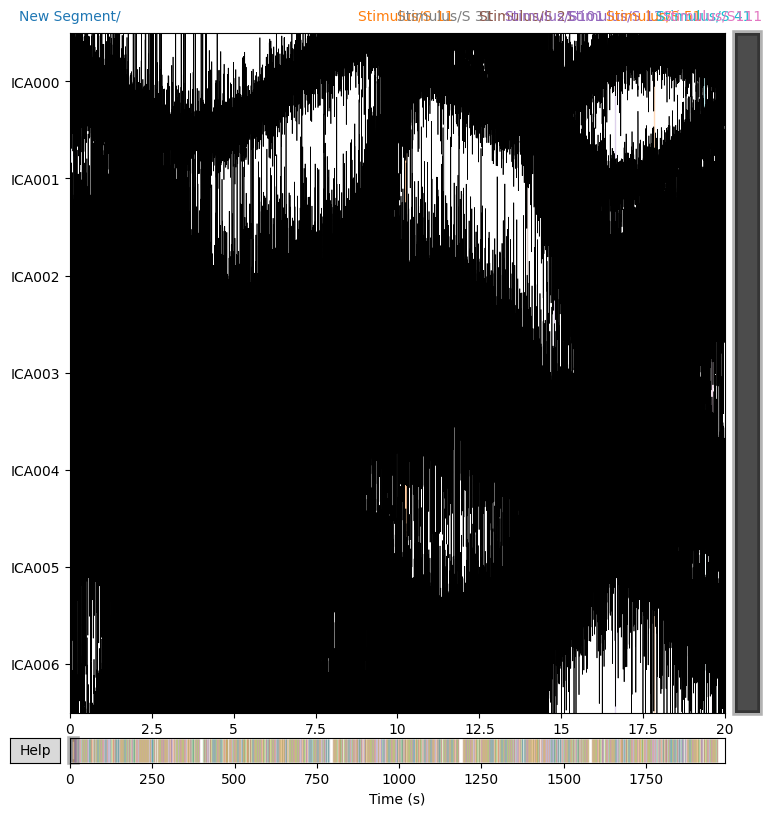

In [10]:
#Plotting the components
ica.plot_components();

#Plotting the time course of the components
ica.plot_sources(raw);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
995 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
995 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
995 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
995 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
995 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
995 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
995 matching events found
No baseline correction applied
0 projection items activated


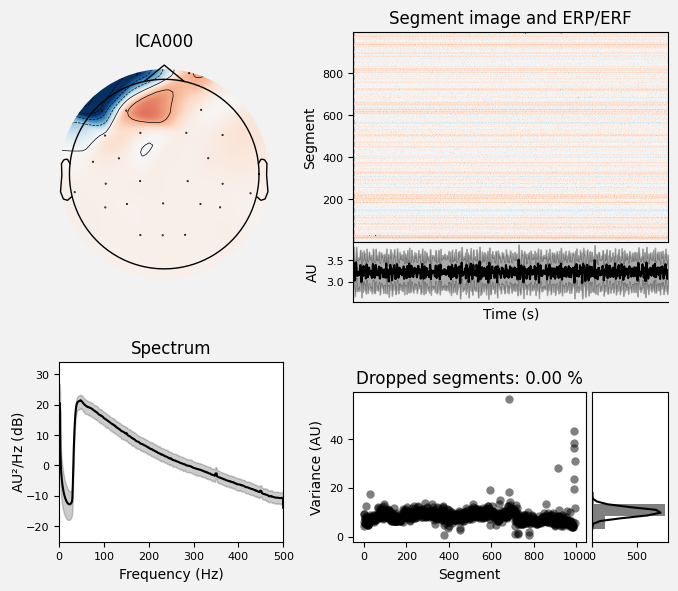

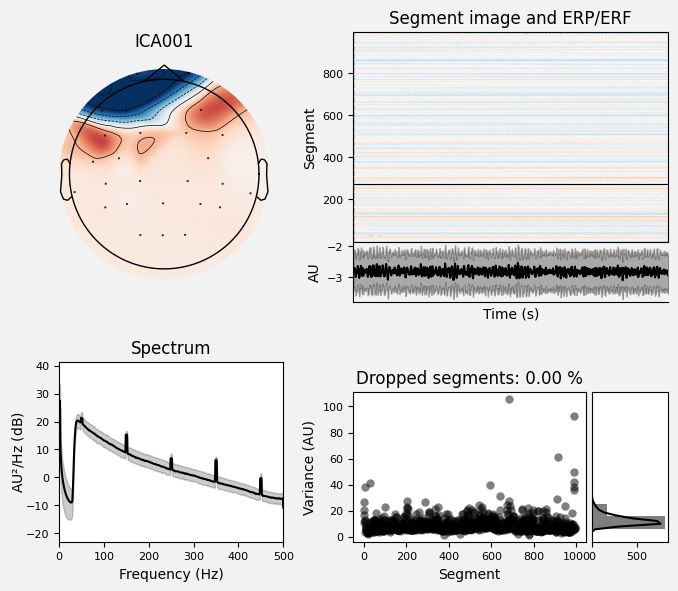

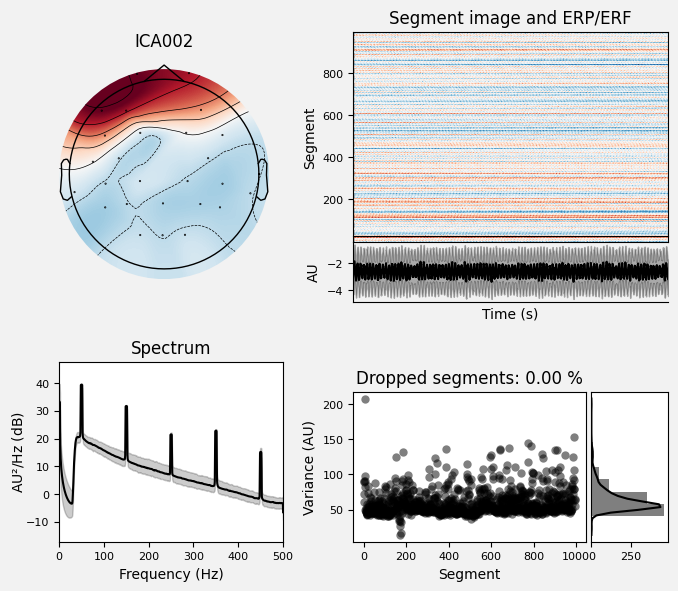

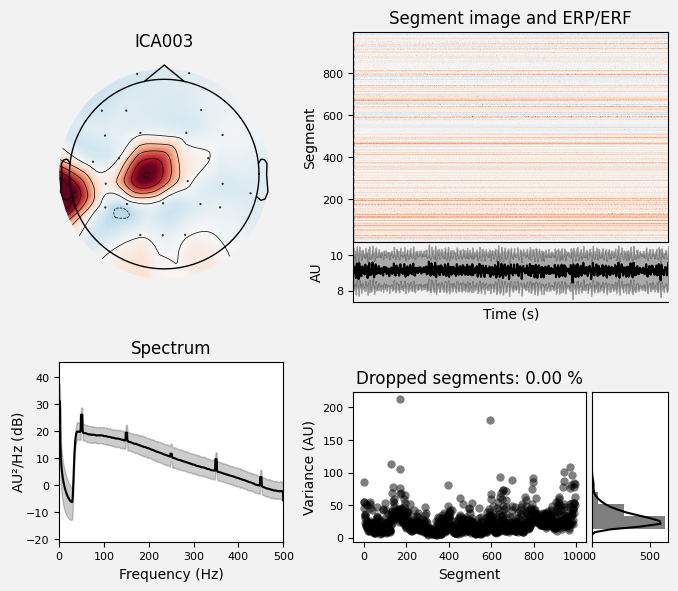

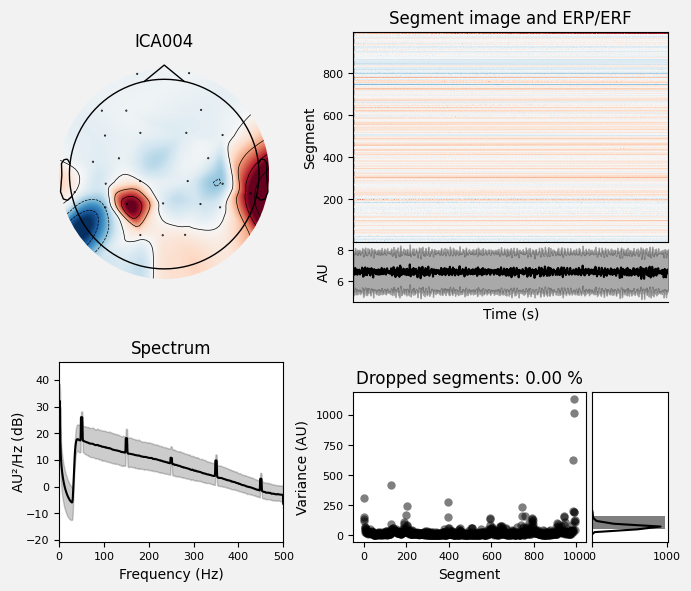

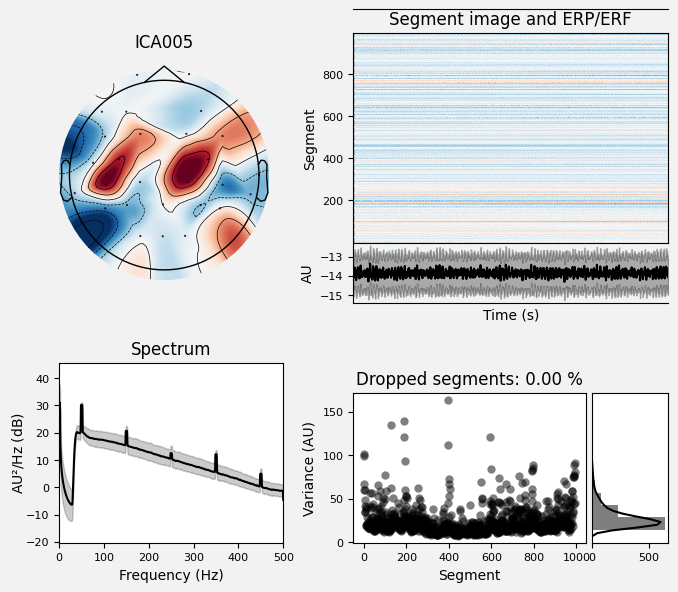

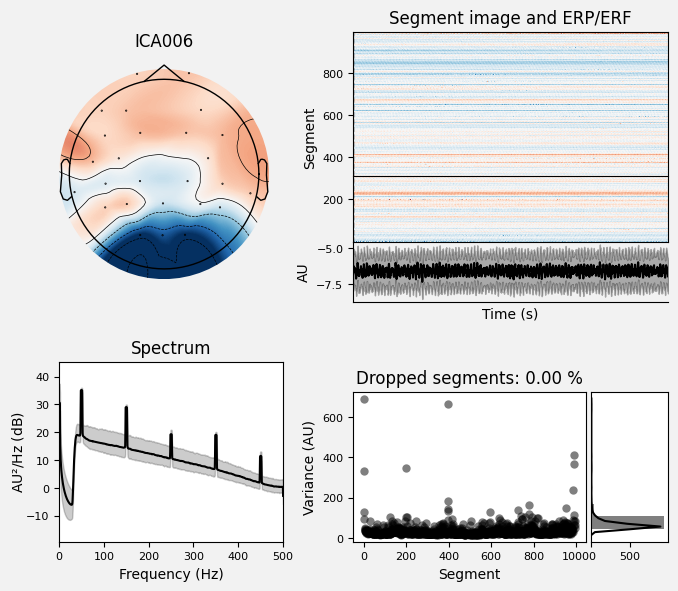

In [11]:
ica.exclude = [0, 1, 2, 3, 4, 5, 6] # setting the exclude argument to the noise components
ica.plot_properties(raw, picks=ica.exclude); # plotting the components that will be excluded (sanity check, did we index the right ones?)

In [12]:
ica.apply(raw) #Applying the exclusion on the raw data

Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 7 ICA components
    Projecting back using 26 PCA components


<RawBrainVision | group1.eeg, 26 x 1990220 (1990.2 s), ~394.8 MB, data loaded>

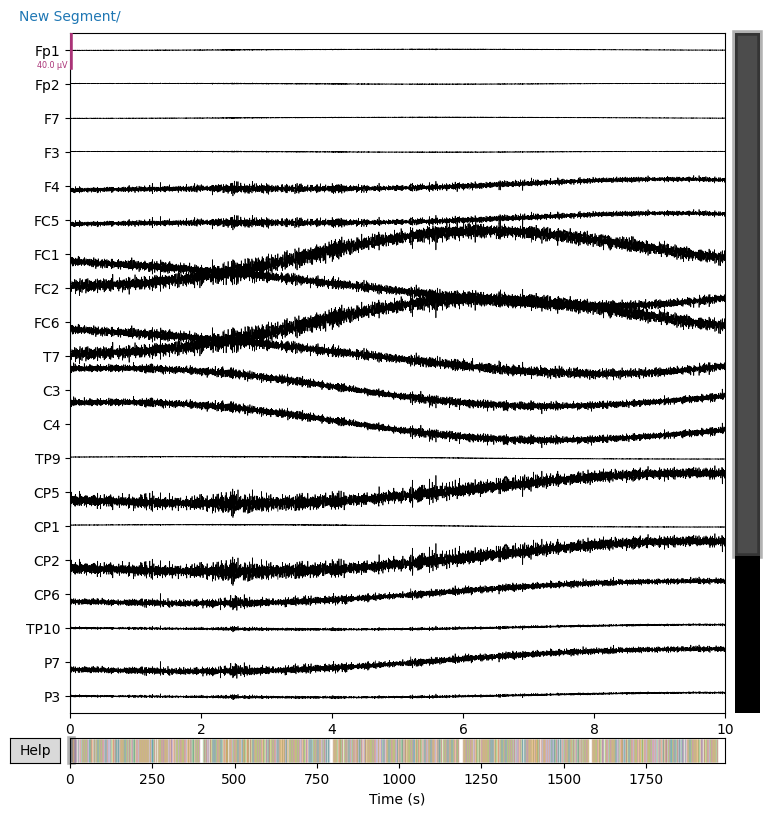

In [13]:
#Plot the data after excluding
raw.plot();

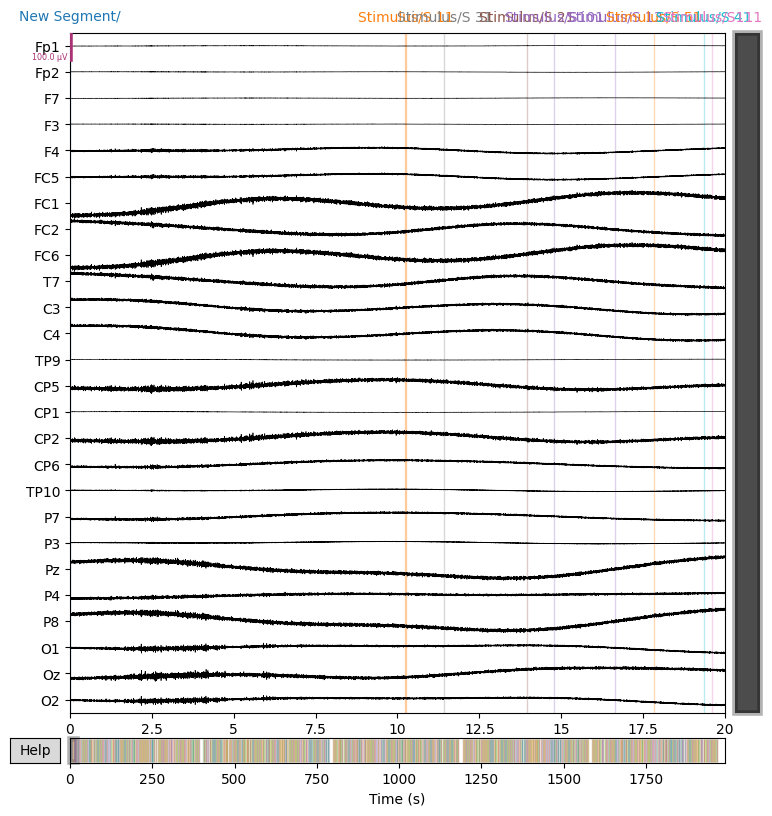

In [14]:
##Plotting after filtering
raw.plot(n_channels=30, duration=20, scalings=dict(eeg=50e-6));

# 2 -- Epoching the data


In [15]:
mne.events_from_annotations(raw)[0]


Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S211', 'Stimulus/S212']


array([[      0,       0,   99999],
       [  10244,       0,      11],
       [  11428,       0,      31],
       ...,
       [1964512,       0,      32],
       [1967030,       0,      22],
       [1967414,       0,     102]])

In [16]:
event_id = {
    'Word/wPos': 11, # positive word
    'Wait/wPos': 31, # waiting time after positive word
    'Image/wPos': 21, # positive image (always following pos word)
    'Word/wNeg': 12, # negative word
    'Wait/wNeg': 32, # waiting time after negative word
    'Image/wNeg': 22, # negative image (always following neg word)
    'Word/wNeu': 13, # neutral word
    'Wait/wNeu/iPos': 51, # wait time after neu w (before pos i)
    'Image/wNeu/iPos': 41, # positive image (after neu word)
    'Wait/wNeu/iNeg': 52, # wait time after neu w (before neg i)
    'Image/wNeu/iNeg': 42, # negative image (after neu word)
 #'Correct/wPos': 101, # correct response ('b') to pos w + image
 #'Correct/wNeg': 102, # correct response ('y') to neg w + image
 #'Correct/wNeu/iPos': 111, # cor resp ('b') to neu w + pos image
 #'Correct/wNeu/iNeg': 112, # cor resp ('y') to neu w + neg image
 #'Incorrect/wPos': 202, # incor resp ('y') to pos w + image
 #'Incorrect/wNeg': 201, # incor resp ('b') to neg w + image
 #'Incorrect/wNeu/iPos': 212, # incor resp ('y') to neu w + pos i
 #'Incorrect/Neu/iNeg': 211, # incor resp ('b') to neu w + neg i
 }

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S211', 'Stimulus/S212']


C:\Users\gerga\AppData\Local\Temp\ipykernel_23852\1244605271.py:3: RuntimeWarning: event 101 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);
C:\Users\gerga\AppData\Local\Temp\ipykernel_23852\1244605271.py:3: RuntimeWarning: event 102 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);
C:\Users\gerga\AppData\Local\Temp\ipykernel_23852\1244605271.py:3: RuntimeWarning: event 111 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);
C:\Users\gerga\AppData\Local\Temp\ipykernel_23852\1244605271.py:3: RuntimeWarning: event 112 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);
C:\Users\gerga\AppData\Local\Temp\ipykernel_23852\1244605271.py:3: RuntimeWarning: event 201 missing from event_id will be i

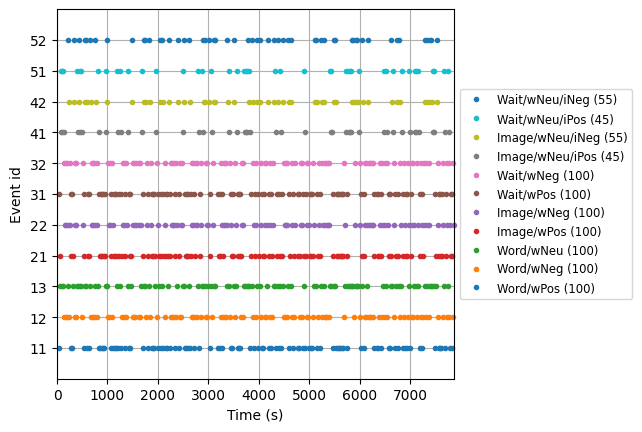

In [17]:
events = mne.events_from_annotations(raw)[0]

mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);

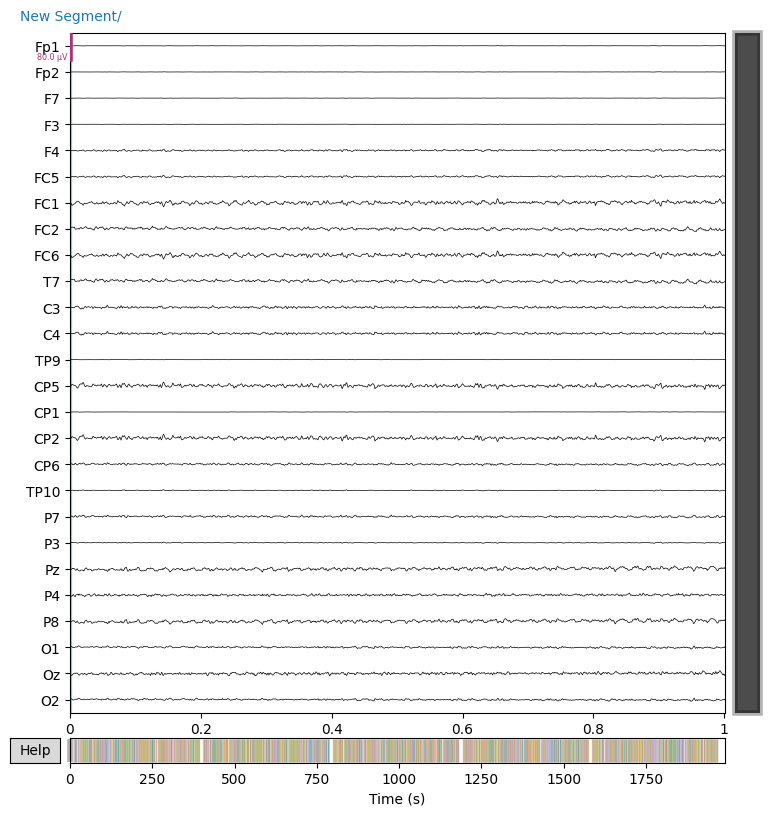

Not setting metadata
900 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 900 events and 801 original time points ...
0 bad epochs dropped


<Epochs |  900 events (all good), -0.1 – 0.7 s, baseline -0.1 – 0 s, ~143.0 MB, data loaded,
 'Word/wPos': 100
 'Wait/wPos': 100
 'Image/wPos': 100
 'Word/wNeg': 100
 'Wait/wNeg': 100
 'Image/wNeg': 100
 'Word/wNeu': 100
 'Wait/wNeu/iPos': 45
 'Image/wNeu/iPos': 45
 'Wait/wNeu/iNeg': 55
 and 1 more events ...>

In [18]:
# Define time window for epochs:
tmin, tmax = -0.1, 0.7
#create the rejection dictionary
reject = {'eeg': 150e-6} 
raw.plot(n_channels=31, duration=1, scalings=dict(eeg=40e-6));
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, reject=reject, preload=True)
epochs


In [21]:
# Downsample the data:
epochs_resampled = epochs.resample(250)

# 5 -- Compare the models


In [25]:
# Extract positive and negative face epochs
pos_img_epochs = epochs['Image/wPos']
neu_w_pos_img_epochs = epochs['Image/wNeu/iPos']
neg_img_epochs = epochs['Image/wNeg']
neu_w_neg_img_epochs = epochs['Image/wNeu/iNeg']

# Combine positive and negative epochs into one dataset
all_pos_epochs = np.concatenate((pos_img_epochs, neu_w_pos_img_epochs), axis=0)
all_neg_epochs = np.concatenate((neg_img_epochs, neu_w_neg_img_epochs), axis=0)

all_epochs = np.concatenate((all_pos_epochs, all_neg_epochs), axis=0)

# Create labels for positive and negative epochs
positive_labels = np.ones(len(all_pos_epochs))
negative_labels = np.zeros(len(all_neg_epochs))
all_labels = np.concatenate((positive_labels, negative_labels), axis=0)
# Subtract 1 from the label values to convert them to integer labels
all_labels = all_labels.astype(int)


In [26]:
# THIS IS THE RIGHT EEGNet MODEL
# Train and evaluate the EEGNet model
# Separate the test set for the EEGNet model
X_train_eegnet, X_test_eegnet, y_train_eegnet, y_test_eegnet = train_test_split(
    all_epochs, all_labels, test_size=0.2, random_state=42)

X_train_eegnet = np.transpose(X_train_eegnet, (0, 1, 2))  # Swap dimensions
X_train_eegnet = X_train_eegnet.reshape((-1, X_train_eegnet.shape[1], X_train_eegnet.shape[2], 1))
X_test_eegnet = np.transpose(X_test_eegnet, (0, 1, 2))  # Swap dimensions
X_test_eegnet = X_test_eegnet.reshape((-1, X_test_eegnet.shape[1], X_test_eegnet.shape[2], 1))

eegnet_model = EEGNet(nb_classes=2, Chans=26, Samples=200)
eegnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
eegnet_model.fit(X_train_eegnet, y_train_eegnet)
eegnet_predictions = eegnet_model.predict(X_test_eegnet)

binary_predictions_eegnet = np.argmax(eegnet_predictions, axis=1)  # Convert to binary predictions

# Calculate classification metrics
accuracy_eegnet = accuracy_score(y_test_eegnet, binary_predictions_eegnet)
precision_eegnet = precision_score(y_test_eegnet, binary_predictions_eegnet, zero_division = 1)
recall_eegnet = recall_score(y_test_eegnet, binary_predictions_eegnet)
f1_eegnet = f1_score(y_test_eegnet, binary_predictions_eegnet)

# Print the metrics
print("Accuracy for the EEGNet model is: {:.2f}%".format(accuracy_eegnet * 100))
print("Precision for the EEGNet model is: {:.2f}%".format(precision_eegnet * 100))
print("Recall for the EEGNet model is: {:.2f}%".format(recall_eegnet * 100))
print("F1-score for the EEGNet model is: {:.2f}%".format(f1_eegnet * 100))

2/2 [==============================] - 0s 8ms/step
Accuracy for the EEGNet model is: 46.67%
Precision for the EEGNet model is: 46.67%
Recall for the EEGNet model is: 100.00%
F1-score for the EEGNet model is: 63.64%


In [27]:
# Split the data into training and testing sets
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    all_epochs, all_labels, test_size=0.2, random_state=42)

# Reshape the data for the CNN model
X_train_cnn = X_train_cnn.reshape((-1, 26, 200, 1))
X_test_cnn = X_test_cnn.reshape((-1, 26, 200, 1))

# Build and train the CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(26, 200, 1)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=16)

# Evaluate the CNN model on the CNN test set
cnn_predictions = cnn_model.predict(X_test_cnn)
cnn_predictions = np.round(cnn_predictions).flatten()

cnn_accuracy = accuracy_score(y_test_cnn, cnn_predictions)
cnn_precision = precision_score(y_test_cnn, cnn_predictions, zero_division = 1)
cnn_recall = recall_score(y_test_cnn, cnn_predictions)
cnn_f1 = f1_score(y_test_cnn, cnn_predictions)

# Print the metrics
print("Accuracy for the CNN model is: {:.2f}%".format(cnn_accuracy * 100))
print("Precision for the CNN model is: {:.2f}%".format(cnn_precision * 100))
print("Recall for the CNN model is: {:.2f}%".format(cnn_recall * 100))
print("F1-score for the CNN model is: {:.2f}%".format(cnn_f1 * 100))

Epoch 1/5
15/15 [==============================] - 1s 34ms/step - loss: 0.6947 - accuracy: 0.5125
Epoch 2/5
15/15 [==============================] - 1s 35ms/step - loss: 0.6928 - accuracy: 0.5125
Epoch 3/5
15/15 [==============================] - 1s 35ms/step - loss: 0.6934 - accuracy: 0.4458
Epoch 4/5
15/15 [==============================] - 1s 35ms/step - loss: 0.6932 - accuracy: 0.5125
Epoch 5/5
2/2 [==============================] - 0s 16ms/step
Accuracy for the CNN model is: 53.33%
Precision for the CNN model is: 100.00%
Recall for the CNN model is: 0.00%
F1-score for the CNN model is: 0.00%


In [388]:
import tensorflow as tf
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [433]:
# Perform cross-validation
eegnet_predictions = eegnet_model.predict(X_test_eegnet)
class_predictions = np.argmax(eegnet_predictions, axis=1)


# Define the pipeline with EEGNet model

# Convert labels to one-hot encoded format
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=2)

# Define the pipeline with EEGNet model
eegnet_pipeline = Pipeline([
    ('eegnet', EEGNet(nb_classes=2, Chans=26, Samples=200)),
])

# Compile the model
eegnet_pipeline.named_steps['eegnet'].compile(optimizer='adam', loss='sparse_categorical_crossentropy')


# Perform cross-validation
cv_scores_eegnet = cross_val_score(eegnet_pipeline, X_train_eegnet, y_train_onehot, cv=5, scoring='accuracy')


# Print the cross-validation scores
print("EEGNet CV Scores:", cv_scores_eegnet)
print("EEGNet CV Accuracy: {:.2f}% (+/- {:.2f}%)".format(cv_scores_eegnet.mean() * 100, cv_scores_eegnet.std() * 100))



2/2 [==============================] - 0s 12ms/step


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gerga\python3.10\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gerga\python3.10\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\gerga\python3.10\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\gerga\AppData\Local\Temp\__autograph_generated_fileo3aiabc8.py", line 15, in tf__train_function
    retval_ = ag__.converted_call(ag__.ld(step_function), (ag__.ld(self), ag__.ld(iterator)), None, fscope)
ValueError: in user code:

    File "C:\Users\gerga\python3.10\Lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\gerga\python3.10\Lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\gerga\python3.10\Lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\gerga\python3.10\Lib\site-packages\keras\engine\training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\gerga\python3.10\Lib\site-packages\keras\engine\training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "C:\Users\gerga\python3.10\Lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\gerga\python3.10\Lib\site-packages\keras\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\gerga\python3.10\Lib\site-packages\keras\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\gerga\python3.10\Lib\site-packages\keras\losses.py", line 2078, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "C:\Users\gerga\python3.10\Lib\site-packages\keras\backend.py", line 5660, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(64,) and logits.shape=(32, 2)



In [396]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

# Define a function to create your Keras model
def create_model():
    # Build your CNN model here
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(26, 200, 1)))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dense(1, activation='sigmoid'))

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return cnn_model

# Create an instance of KerasClassifier with your model creation function
estimator_cnn = KerasClassifier(build_fn=create_model, epochs=10, batch_size=16)

# Use cross_val_score with the KerasClassifier
cv_scores_cnn = cross_val_score(estimator_cnn, X_train_cnn, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores_cnn)
print('Mean accuracy:', np.mean(cv_scores_cnn))


Epoch 1/10


C:\Users\gerga\AppData\Local\Temp\ipykernel_6748\3757257681.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator_cnn = KerasClassifier(build_fn=create_model, epochs=10, batch_size=16)


12/12 [==============================] - 2s 38ms/step - loss: 0.6934 - accuracy: 0.4844
Epoch 2/10
12/12 [==============================] - 0s 37ms/step - loss: 0.6930 - accuracy: 0.5365
Epoch 3/10
12/12 [==============================] - 0s 37ms/step - loss: 0.6923 - accuracy: 0.5365
Epoch 4/10
12/12 [==============================] - 0s 37ms/step - loss: 0.6919 - accuracy: 0.5365
Epoch 5/10
12/12 [==============================] - 0s 36ms/step - loss: 0.6919 - accuracy: 0.5365
Epoch 6/10
12/12 [==============================] - 0s 36ms/step - loss: 0.6914 - accuracy: 0.5365
Epoch 7/10
12/12 [==============================] - 0s 37ms/step - loss: 0.6912 - accuracy: 0.5365
Epoch 8/10
12/12 [==============================] - 0s 36ms/step - loss: 0.6911 - accuracy: 0.5365
Epoch 9/10
12/12 [==============================] - 0s 38ms/step - loss: 0.6909 - accuracy: 0.5365
Epoch 10/10
2/2 [==============================] - 0s 12ms/step
Epoch 1/10
12/12 [==============================] - 1s 4

In [259]:
# Specify electrode locations
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)

<RawBrainVision | group1.eeg, 28 x 1990220 (1990.2 s), ~425.2 MB, data loaded>

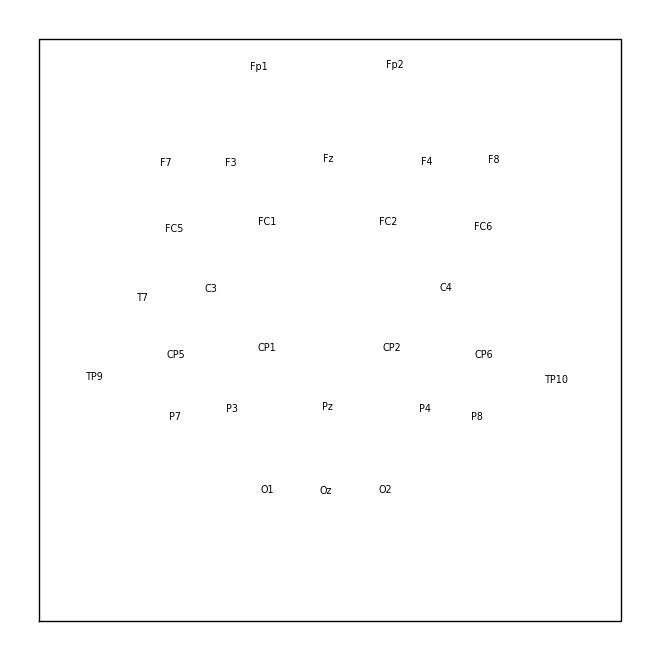

In [255]:
# Electrode layout
layout_from_raw = mne.channels.make_eeg_layout(raw.info)
layout_from_raw.plot();